# Discussion section week 3: Prediction

This week we'll recap the concepts we've talked about over the last few weeks.

Topics:

- Population model
- Training error vs test error
- Model selection
- Cross validation


## Example: estimating mean

Suppose we get data $Y_1, \ldots Y_n$. 
We want to find value $c$ that minimizes the loss function $(Y-c)^2$.
That is:
$$ l(c, Y) = \sum_i (Y_i - c)^2 $$
Now we want
$$ c = \arg\min \sum_i (Y_i - c)^2 $$

Solution: take derivate with respect to c:

$$ \frac{d}{dc} \sum_i (Y_i - c)^2 = -2c \sum_i (Y_i - c)$$

Setting this equal to zero:
$$ 2\hat{c}\sum_i Y_i = 2n\hat{c} $$
which simplifies to
$$ \hat{c} = \frac{1}{n} \sum_i Y_i  = \bar{Y}$$

Hence, the number that minimizes the loss on the training set is the mean of the observations.
This should not come as a big surprise.

One important side note; while we might think about $\hat{c}$ as a constant, it is really a random variable, as it is a function of the (training) data, which itself is random. If we would resample our data, we also get a different estimate $\hat{c}$.

Let's simulate some data and see what's going on.
Here, we will take a very simple model such that we can also analyze it:

$$ Y_i \sim N(0, 1)$$

In [2]:
library(data.table)
library(plyr)
library(dplyr)
library(ggplot2)
library(tibble)

options(repr.plot.width=5, repr.plot.height=3)

In [3]:
loss <- function(c, Y) {
    mean((c - Y)^2)
}

sim_mean <- function (n) {
    Y <- rnorm(n)
    c.hat <- mean(Y)
    Y.new <- rnorm(100)
    list(train.loss = loss(c.hat, Y), test.loss = loss(c.hat, Y.new))
}

In [4]:
Ns <- rep(seq(1, 10), each=500)
df <- as_tibble(rbindlist(llply(Ns, sim_mean)))
df$n <- as.factor(Ns)

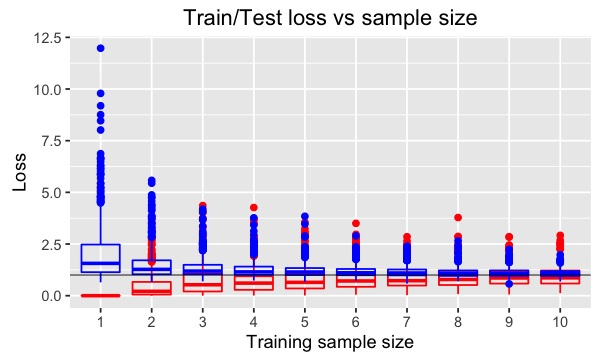

In [5]:
df %>% ggplot(aes(x=n)) + 
    geom_boxplot(aes(y=train.loss, group=n), color="red", fill=NA) + 
    geom_boxplot(aes(y=test.loss, group=n), color="blue", fill=NA) + 
    geom_hline(aes(yintercept=1), alpha=0.5) +
    labs(title="Train/Test loss vs sample size",
        x="Training sample size", y="Loss")

Warning message:
“Removed 22 rows containing non-finite values (stat_density).”

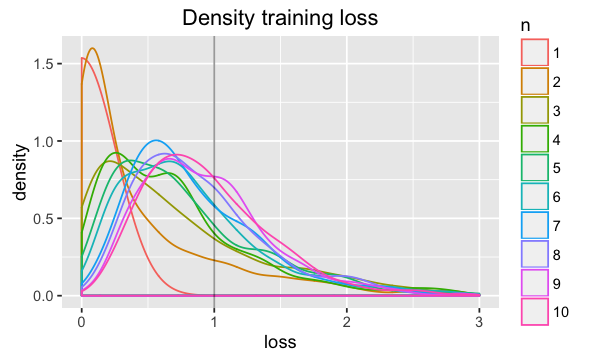

In [6]:
df %>% ggplot() + 
    geom_density(aes(x=train.loss, color=n), fill=NA) + 
    geom_vline(aes(xintercept=1), alpha=0.4) +
    xlim(0, 3) + 
    labs(title="Density training loss",
        x="loss", y="density")

Warning message:
“Removed 121 rows containing non-finite values (stat_density).”

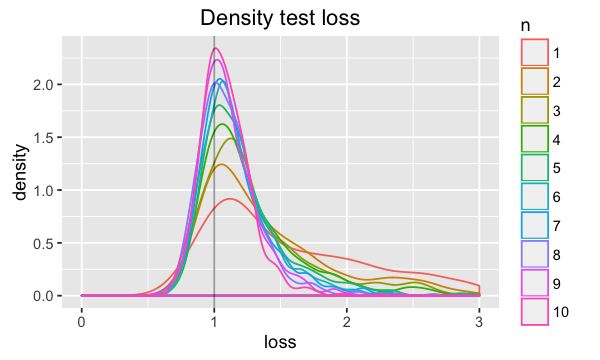

In [7]:
df %>% ggplot() + 
    geom_density(aes(x=test.loss, color=n), fill=NA) + 
    geom_vline(aes(xintercept=1), alpha=0.4) +
    xlim(0, 3) + 
    labs(title="Density test loss",
        x="loss", y="density")

## What we notice

Note I divided loss by the number of samples, $n$, such that it is easier to compare across $n$.

As we get more data:

- the training loss goes up, and 
- the test loss goes down

Why?

**Training loss**: 
First we note that if we only have one sample, $\hat{c} = Y_1$, and hence the loss is 0.
Note that $\hat{c}$ captures the deviation from the mean exactly.

As we get more data, we cannot get 0 training loss, as we have to average errors. 
This means our training loss slowly goes up.

More mathematically, we know from Probability 101 that
$$\bar{Y} \sim N(0, 1/n) \to 0$$

Hence, as we get more and more data, $\hat{c}$ converges to 0. 
In that case, the average loss would be $1$, exactly the variance of the noise around the mean!

Note that if an oracle told you that the mean of $Y$ is 0, then we can use $c^* = 0$.
But this leads to an expected training loss of $1$. 
And in particular, the loss of $c^*$ is **always** worse than $\hat{c}$ on training data. 

**Test loss**:
We note that
$$E[l(Y, c)] = E[(Y-c)^2] = E[(Y - 0 + 0 - c)^2] =^* E[Y^2 + c^2] = 1 + \frac{1}{n}$$
The $=^*$ follows from the new data point Y and the average over the training set are independent, hence the cross terms are 0.
As we obtain more data, our estimate of the mean of $Y$ improves, and our test error goes down.

Note that the first part in the test loss is called the *irreducible error*. 
Even if you knew in advance that the mean of $Y$ is 0, then you'd still have an expected loss of 1 due to the randomness in the test set.

**The take-away is that the performance of your model on the data that was used to train it, is always optimistic!**

Why is this important? We want to predict outcomes on unseen data. 
Suppose we come up with two models and have to decide which one we want to use.
We just saw that training loss (and similar measures based on training data, such as $R^2$) is not a good measure for performance on new data.
Hence, to decide what model to use, we need to find a different measure.

## Quantifying prediction performance

Most straightforward and widely applicable approach: split your data randomly in a training set (on which to train a model) and a test set (on which to quantify the prediction performance).

In [80]:
n <- 5
delta <- 0.1

gen.data <- function(n, delta) {
    y.red <- rnorm(n) + delta/2
    y.blue <- rnorm(n) - delta/2
    color <- c(rep('R', n), rep('B', n))

    tibble(y=c(y.red, y.blue), color=color)
}

perf.simple <- function(train, test) {
    model <- lm(y ~ 1, data=train)
    mean((test$y - predict(model, test))^2)
}

perf.color <- function(train, test) {
    model <- lm(y ~ 1 + color, data=train)
    mean((test$y - predict(model, test))^2)
}

In [81]:
set.seed(102)
data <- gen.data(n, delta)

data

y,color
0.2305229,R
0.8347340,R
-1.3031646,R
2.0332982,R
1.2884717,R
1.1506174,B
0.8461499,B
0.2036898,B
0.4996003,B
1.8533711,B


First, let's see what happens if we simply train the two models on the full data set and then use those same observations to compute the error.

In [82]:
# the bad approach, using training error:
p.simple <- perf.simple(data, data)
p.color <- perf.color(data, data)

cat("Training loss model:", p.simple, "\nTraining loss full model:", p.color)

Training loss model: 0.8175764 
Training loss full model: 0.7959801

As expected, the in sample loss on the simple model is larger than on the full model.
However, we now know that comparing these numbers is useless.

### Train - test split

To mitigate this problem, we can split the data into a training set and test set. 
It is important to select these at random (and sometimes one has to be rather careful to randomize properly, for example with time series).

In [97]:
# train test split
n.train <- floor(0.7*nrow(data))
train.idx <- sample(nrow(data), size=n.train)
train <- data[train.idx,]
test <- data[-train.idx,]

test.simple <- perf.simple(train, test)
test.color <- perf.color(train, test)

cat("Test loss simple model:", test.simple, "\nTest loss full model:", test.color)

Test loss simple model: 0.9230893 
Test loss full model: 2.199312

These give us unbiased estimates of the test error. 
There is one problem though; we only have 10 observations and thus there is a lot of randomness in our estimates.
Furthermore, we are wasting a lot of data using this approach, and in certain situations, we do not have the luxury to squander our data. This is the case here, because we have only 10 observations!

### Cross validation

We can make optimal use of our data by creating multiple train-test splits and averaging over the test losses.
Here, we choose to do *Leave One Out Cross Validation*, which is K-fold cross validation where K is the number of samples. 

That is, we train our model on all but one data point, and compute the error on that point. 
We repeat this process for every data point in the sample, and average the result to get a good estimate of our prediction error!

**Disadvantages**

What are the disadvantages of cross-validation?

- Computationally intensive in many scenarios; what if training a model takes a day (e.g. neural networks)
- Have to be very careful about model selection; what happens if I first look at a scatterplot of outcome versus covariates to select which covariates to use, and then use CV to estimate prediction error?

In [98]:
# leave one out CV
cv.simple <- mean(sapply(1:nrow(data), function (i) {perf.simple(data[-i,], data[i,])}))
cv.color <- mean(sapply(1:nrow(data), function (i) {perf.color(data[-i,], data[i,])}))

cat("CV loss simple model:", cv.simple, "\nCV loss full model:", cv.color)

CV loss simple model: 1.009354 
CV loss full model: 1.243719

## Time to cheat

Finally, let's cheat by generating lots of data (as a surrogate for access to the population model) and see what model performs better:

In [90]:
population <- gen.data(1000000, delta)

pop.simple <- perf.simple(data, population)
pop.color <- perf.color(data, population)

cat("Loss simple model:", pop.simple, "\nLoss full model:", pop.color)

Loss simple model: 1.587986 
Loss full model: 1.624137

We see that the simple model actually performs better!

**Up next:** How come the simple model is better than the full model, even though the full model is the "correct" model?